<hr style="border-color:coral; border-width:4px"></hr>

# MPI Output

<hr style="border-color:coral; border-width:4px"></hr>

In [1]:
%matplotlib notebook
%pylab

Using matplotlib backend: nbAgg
Populating the interactive namespace from numpy and matplotlib


In [6]:
%%bash

rm -rf gridsoln.out

mpicc -o output output.c -lm

mpirun -n 4 output 10 2 2 21

In [7]:
%%bash 

ls -l gridsoln.out


-rw-r--r-- 1 calhoun staff 176505216 Apr  1 08:56 gridsoln.out


In [8]:
# Check the size of the file for 
#
#      mpirun -n 2 output <p> 2 1 <mout>
#
# Include 4-byte padding in the header to get required byte alignment.

size_int = 4
size_double = 8

p = 10
mout = 21
nx = 2**p

header = 4*size_double + 3*size_int + 1*size_int
grid = (nx+1)**2
bytecount = header + size_double*mout*(grid + 1)
print("Expected bytecount : {:d}".format(bytecount))

Expected bytecount : 176505216


In [9]:
# Open file for reading; use binary mode
fout = open("gridsoln.out","rb")

# Read meta data
dt_meta = dtype([('xgrid','d',2),('ygrid','d',2),('N','int32',2),('Mout','int32'),('pad','int32')])
d = fromfile(fout,dtype=dt_meta, count=1)

# create dictionary containing meta data
parms = {}
for i,k in enumerate(dt_meta.fields):
    parms[k] = d[k][0]
    
xgrid,ygrid,N,Mout,pad = d[0]
Nx = N[0]
Ny = N[1]
ax = xgrid[0]
bx = xgrid[1]
ay = ygrid[0]
by = ygrid[1]


# Print meta data from dictionary
print("Mesh cell dimensions : ({:2d},{:2d})".format(Nx,Ny))
print("")
print("Domain : [{:g},{:g}] x [{:g},{:g}]".format(ax,bx,ay,by))
print("")
print("Total number of expected time steps : {:d}".format(Mout))
print("")

# Assign values in tuple directly (for use below)


# Read solution data and count number of output steps.  This should match number
# set by the user in call to `heat2d`
# dt_heat = dtype([('t','d'),('q','d',(Nx+1)*(Ny+1))])  
dt_heat = dtype([('t','d'),('q','d',(Nx+1)*(Ny+1))])  
data = fromfile(fout,dtype=dt_heat)
Mout = len(data) # Number of time steps output.
print("Number of actual output steps : {:d}".format(Mout))

# Close file
fout.close()

Mesh cell dimensions : (1024,1024)

Domain : [0,1] x [0,1]

Total number of expected time steps : 21

Number of actual output steps : 21


In [10]:
xe = linspace(ax,bx,Nx+1)
ye = linspace(ay,by,Ny+1)

dx = (bx-ax)/Nx
dy = (by-ay)/Ny

[xm,ym] = meshgrid(xe,ye,indexing='ij')

<IPython.core.display.Javascript object>


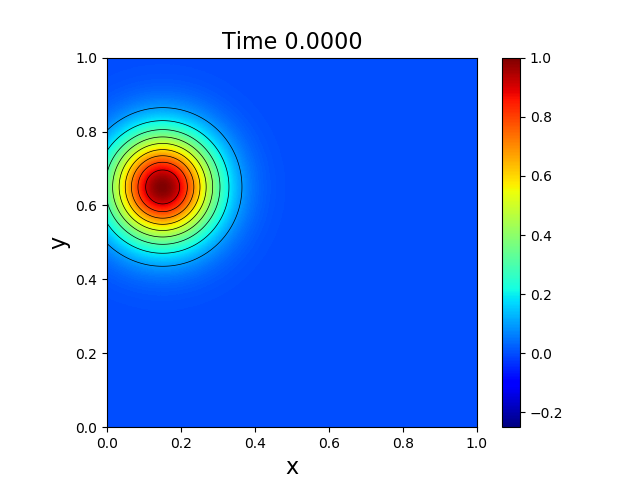

In [11]:
# Plot initial conditions
figure(1)
clf()

set_cmap('jet')

q = reshape(data[0][1],(Nx+1,Ny+1))
mesh = pcolormesh(xm,ym,q,vmin=-0.25,vmax=1)

cv = linspace(-1,1,21)
cv = cv[1:]   # avoid 0 contours
cont = contour(xm,ym,q,colors='k',levels=cv,linewidths=0.5)

gca().set_aspect(1)

title('Time {:0.4f}'.format(0),fontsize=16)
xlabel('x',fontsize=16)
ylabel('y', fontsize=16)

colorbar(mesh)

show()

<IPython.core.display.Javascript object>


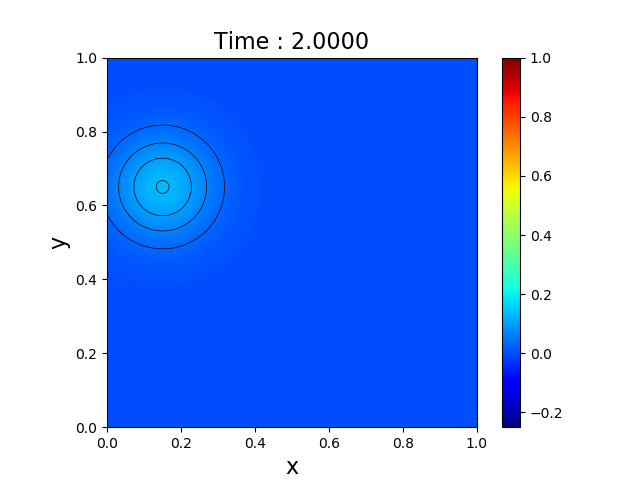

qmax =   1.35333218e-01
qmin =   1.85375334e-26


In [12]:
# Plot initial solution and store handle
fig = figure(2)
clf()

q = reshape(data[0][1],(Nx+1,Ny+1))
mesh = pcolormesh(xm,ym,q,shading='flat',vmin=-0.25,vmax=1)
    
# Set up contour lines
cv = linspace(0,1,31)
cv = cv[1:]   # avoid 0 contours
cont = contour(xm,ym,q,colors='k',levels=cv,linewidths=0.5)

# Add title, axis labels, etc
htitle = title('Time : {:.4f}'.format(0),fontsize=16)
xlabel('x',fontsize=16)
ylabel('y', fontsize=16) 

colorbar(mesh)

# Make axis square
gca().set_aspect(1)

# Refresh plot
fig.canvas.draw()     

pause(0.05)

for n in range(0,Mout):

    t = data[n][0]
    
    q = reshape(data[n][1],(Nx+1,Ny+1))
    # q = data[n][1]
    mesh.set_array(q[:-1,:-1].ravel())

    # Plot contour lines
    for c in cont.collections:
        c.remove()
    cont = contour(xm,ym,q,colors='k',levels=cv,linewidths=0.5)

    # Update title with new time
    htitle.set_text('Time : {:.4f}'.format(t))

    # Make axis square
    gca().set_aspect(1)

    # Refresh plot
    fig.canvas.draw()        
    
    pause(0.05)
    
print("qmax = {:16.8e}".format(q.max()))
print("qmin = {:16.8e}".format(q.min()))